<a href="https://colab.research.google.com/github/iber-uio/IN4310/blob/main/IN4310_Project_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 1:** Data splitting and classification

Perform a train-val-test split of the data, and use a manual seed so that you and us can reproduce the same split your experiments. Split the 17034 images into 3k for testing, 2k for validation and the remainder for training. Split every class separately (stratified splitting).

In [ ]:
import os
import copy
import shutil
import pickle
import tarfile
import zipfile
import datetime
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
from tabulate import tabulate
from google.colab import drive
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from matplotlib.ticker import LogLocator
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, classification_report
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# Set the project folder
project_folder = '/content/drive/My Drive/IN4310/'
mount_point = '/content/drive/'
data_folder = '/content/data'

# Set the Image dataset file
src_file = 'mandatory1_data.zip'

# Define dataset paths
dataset_paths = {
    'buildings': 'data/buildings/',
    'forest': 'data/forest/',
    'glacier': 'data/glacier/',
    'mountain': 'data/mountain/',
    'sea': 'data/sea/',
    'street': 'data/street/',
}

In [ ]:
# Unzip files into a temporary Google Colab folder to improve IO efficiency

# Delete existing data folders if they exist
if os.path.exists(data_folder):
    shutil.rmtree(data_folder)
if os.path.exists('/content/mandatory1_data'):
    shutil.rmtree('/content/mandatory1_data')

# Unzip files into a temporary Google Colab folder to improve IO efficiency
if not os.path.exists(mount_point):
    drive.mount(mount_point)
else:
    print(f"Drive is already mounted at {mount_point}\n")

os.chdir(os.path.join(mount_point, project_folder))

# Create the destination folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Create the 'accuracy' folder in the project folder on Google Drive if it doesn't exist
accuracy_folder = os.path.join(mount_point, project_folder, 'accuracy')

if not os.path.exists(accuracy_folder):
    os.makedirs(accuracy_folder)

#print(f"Files in the directory {accuracy_folder}:\n")
#for file in os.listdir(accuracy_folder):
#    print(file)

# Create the 'softmax' folder in the project folder on Google Drive if it doesn't exist
softmax_folder = os.path.join(mount_point, project_folder, 'softmax')

if not os.path.exists(softmax_folder):
    os.makedirs(softmax_folder)

# Download the zip file
with tqdm(total=os.path.getsize(src_file), desc="Downloading", unit="B", unit_scale=True) as pbar:
    with open(src_file, "rb") as src, open('/content/mandatory1_data.zip', "wb") as dst:
        for chunk in iter(lambda: src.read(1024 * 1024), b""):
            dst.write(chunk)
            pbar.update(len(chunk))

# Extract the zip file
with zipfile.ZipFile('/content/mandatory1_data.zip', 'r') as zip_ref:
    with tqdm(total=len(zip_ref.infolist()), desc="Extracting.....", unit="file") as pbar:
        for member in zip_ref.infolist():
            zip_ref.extract(member, '/content/')
            pbar.update(1)

# Rename the extracted folder from mandatory1_data to data
if os.path.exists('/content/mandatory1_data'):
    os.rename('/content/mandatory1_data', data_folder)

if os.path.exists('/content/mandatory1_data.zip'):
    os.remove('/content/mandatory1_data.zip')
    
print("Files extracted successfully.")

os.chdir('/content/')

if not os.path.exists(data_folder):
    num_files = 0
else:
    num_files = 0
    for root, dirs, files in os.walk(data_folder):
        num_files += len(files)

print(f'\nThere are {num_files} files in the destination folder: {data_folder}')

Mounted at /content/drive/


Downloading:   0%|          | 0.00/254M [00:00<?, ?B/s]

Extracting.....:   0%|          | 0/17041 [00:00<?, ?file/s]

Files extracted successfully.

There are 17034 files in the destination folder: /content/data


In [ ]:
src_file_cifar = 'cifar-10-python.tar.gz'
src_url_cifar = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

# Delete existing data folders if they exist
if os.path.exists('/cifar-10'):
    shutil.rmtree('/cifar-10')

if os.path.exists('/cifar-10-batches-py'):
    shutil.rmtree('/cifar-10-batches-py')  

# Create the destination folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Download the tar.gz file
def download_progress_hook(count, block_size, total_size):
    global pbar
    pbar.update(block_size)

with tqdm(total=None, desc="Downloading", unit="B", unit_scale=True) as pbar:
    urllib.request.urlretrieve(src_url_cifar, filename=src_file_cifar, reporthook=download_progress_hook)

# Extract the tar.gz file
with tarfile.open(src_file_cifar, 'r:gz') as tar_ref:
    with tqdm(total=len(tar_ref.getmembers()), desc="Extracting", unit="file") as pbar:
        for member in tar_ref.getmembers():
            tar_ref.extract(member, data_folder)
            pbar.update(1)

# Rename the extracted folder from cifar-10-batches-py to cifar-10
if os.path.exists(os.path.join(data_folder, 'cifar-10-batches-py')):
    os.rename(os.path.join(data_folder, 'cifar-10-batches-py'), os.path.join(data_folder, 'cifar-10'))

# Remove the downloaded tar.gz file
if os.path.exists(src_file_cifar):
    os.remove(src_file_cifar)

print("CIFAR-10 dataset downloaded and extracted successfully.")

Downloading: 0.00B [00:00, ?B/s]

Extracting:   0%|          | 0/9 [00:00<?, ?file/s]

CIFAR-10 dataset downloaded and extracted successfully.


In [ ]:
# Load data and create stratified train, val, and test sets
data = []
labels = []

num_images_per_class = 2500

for i, class_name in enumerate(dataset_paths):
    class_files = os.listdir(dataset_paths[class_name])
    selected_files = np.random.choice(class_files, num_images_per_class, replace=False)

    for file in selected_files:
        data.append(os.path.join(dataset_paths[class_name], file))
        labels.append(i)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=42, stratify=labels) # 10% images for test
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42, stratify=train_labels) # 18% images for validation

Verify that obtained splits are disjoint

In [ ]:
# Verify the splits are disjoint
def verify_dj(train_data, val_data, test_data):
    all_data = np.concatenate((train_data, val_data, test_data))
    unique_data = set(all_data)

    if len(unique_data) == len(all_data):
        print("The splits are disjoint")
    else:
        print("There are common elements between the splits")

# Call the function to verify the splits
verify_dj(train_data, val_data, test_data)

The splits are disjoint


In [ ]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'visualization': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

Dataloaders for the train, validation and test dataset parts

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path, label = self.file_list[index]  # Get the img_path and label directly from the file_list
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label, os.path.basename(img_path)

In [ ]:
# Create dataset instances for train, val, and test sets (v2)

train_dataset = Dataset([(train_data[i], train_labels[i]) for i in range(len(train_data))], transform=data_transforms['train'])
val_dataset = Dataset([(val_data[i], val_labels[i]) for i in range(len(val_data))], transform=data_transforms['valid'])
test_dataset = Dataset([(test_data[i], test_labels[i]) for i in range(len(test_data))], transform=data_transforms['test'])

num_workers = 0
batch_size = 64

# Create dataloaders for train, val, and test sets
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'valid': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

Choose a neural network of your likes, train using finetuning

In [ ]:
# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize dictionaries to store losses and accuracies for each hyperparameter
all_train_losses = {}
all_train_accuracies = {}
all_val_losses = {}
all_val_accuracies = {}
all_learning_rates = {}

data_dicts = [all_train_accuracies, all_train_losses, all_val_accuracies, all_val_losses, all_learning_rates]

# Save dictionaries to files
pickle_files = [
    "all_train_accuracies.pickle",
    "all_train_losses.pickle",
    "all_val_accuracies.pickle",
    "all_val_losses.pickle",
    "all_learning_rates.pickle",]

def convert_to_cpu(tensor_list):
    return [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensor_list]

def save_dicts_to_files(file_prefix, data_dicts, accuracy_folder):
    for data_dict, file in zip(data_dicts, pickle_files):
        file_name = os.path.join(accuracy_folder, f"{file[:-7]}{file_prefix}.pickle")
        with open(file_name, "wb") as handle:
            converted_dict = {k: [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in v] for k, v in data_dict.items()}
            pickle.dump(converted_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_dicts_from_files(pickle_files, accuracy_folder):
    loaded_dicts = []
    for file in pickle_files:
        file_name = os.path.join(accuracy_folder, file)
        with open(file_name, "rb") as handle:
            data_dict = pickle.load(handle)
                    
            # Convert to CPU
            data_dict_cpu = {k: convert_to_cpu(v) for k, v in data_dict.items()}
            loaded_dicts.append(data_dict_cpu)
    return loaded_dicts

def train_and_evaluate(learning_rate, optimizers, epochs, best_val_acc, best_model_params, metric, lr_patience, early_stopping_patience):

    best_model = None
    
    for opt in optimizers:

        for lr in learning_rate:

            #hp = f'{lr}_{opt}'
            print(f'\n\n\nTraining with learning rate: {lr} and optimizer: {opt}\n\n')

            # Create a new model for each hyperparameter combination
            class_names = list(dataset_paths.keys())

            # Create the model
            model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, len(class_names))
            model = model.to(device)

            criterion = nn.CrossEntropyLoss()

            # Initialize the optimizer based on the selected type
            if opt == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            elif opt == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)

            # Initialize the learning rate scheduler
            scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=lr_patience, verbose=True)

            # Training and validation v2 (with progress monitoring and plots)

            # Initialize lists to store loss and accuracy values
            train_losses = []
            train_accuracies = []
            val_losses = []
            val_accuracies = []
            learning_rates = []

            # Training and validation
            num_epochs = epochs

            # Define early stopping parameters
            #early_stopping_patience = 10  # stop training if the validation performance doesn't improve after this many epochs
            epochs_since_best = 0
            best_val_metric = None

            for epoch in range(num_epochs):
                print(f'\nEpoch {epoch + 1}/{num_epochs}')
                print('-' * 10)

                hp = f'{lr}_{opt}_{epoch + 1}'

                for phase in ['train', 'valid']:
                    if phase == 'train':
                        model.train()
                    else:
                        model.eval()

                    running_loss = 0.0
                    running_corrects = 0
                    num_samples = 0
                    image_filenames = []

                    progress_bar = tqdm(dataloaders[phase], desc=f'{phase} progress')
                    for inputs, labels, filenames in progress_bar:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        optimizer.zero_grad()

                        # Forward pass and calculate the loss
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                            # Backward pass and optimize the weights
                            if phase == 'train':
                                loss.backward()
                                optimizer.step()

                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                        num_samples += inputs.size(0)
                        image_filenames.extend(filenames)  # Add the filenames to the list

                        # Update the progress bar
                        progress_bar.set_postfix(loss=loss.item(), acc=running_corrects.double() / num_samples, refresh=True)

                    epoch_loss = running_loss / num_samples
                    epoch_acc = running_corrects.double() / num_samples

                    print(f'                      loss: {epoch_loss:.4f} accuracy: {epoch_acc * 100:.2f}%')

                    if phase == 'train':
                        train_losses.append(epoch_loss)
                        train_accuracies.append(epoch_acc)
                    else:
                        val_losses.append(epoch_loss)
                        val_accuracies.append(epoch_acc)
                        
                        # Check the learning rate before updating
                        lr_before = optimizer.param_groups[0]['lr']
                        
                        # Update the learning rate based on the validation accuracy
                        scheduler.step(epoch_acc)

                        # Check the learning rate after updating
                        lr_after = optimizer.param_groups[0]['lr']

                        # If the learning rate has changed, print a message
                        if lr_before != lr_after:
                            #print(f'\nLearning rate updated: {lr_before:.8f} -> {lr_after:.8f}\n')
                            print(f'\nLearning rate updated: {round(lr_before, 6)} -> {round(lr_after, 6)}\n')
                        
                        # Append the learning rate to the list
                        learning_rates.append(lr_before)
                
                # Choose the metric based on the 'metric' parameter
                if metric == 'accuracy':
                    val_metric = epoch_acc
                    mode = 'max'
                elif metric == 'loss':
                    val_metric = epoch_loss
                    mode = 'min'
                
                # Update best validation metric and reset the counter
                if best_val_metric is None or (mode == 'max' and val_metric > best_val_metric) or (mode == 'min' and val_metric < best_val_metric):
                    best_val_metric = val_metric
                    epochs_since_best = 0
                else:
                    # Increment the counter if there is no improvement
                    epochs_since_best += 1

                # Check if early stopping condition is met
                if epochs_since_best >= early_stopping_patience:
                    print(f"\nEarly stopping triggered at epoch {epoch + 1}. No significant improvement in the validation metric for {early_stopping_patience} epochs.")
                    break

            # Save the losses and accuracies for the current setting
            all_train_losses[hp] = train_losses
            all_train_accuracies[hp] = train_accuracies
            all_val_losses[hp] = val_losses
            all_val_accuracies[hp] = val_accuracies
            all_learning_rates[hp] = learning_rates

            current_val_acc = max(val_accuracies)
            max_val_acc_epoch = val_accuracies.index(current_val_acc) + 1
            
            # Update the best model if the current validation accuracy is better
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                best_model = model
                best_model_params = {
                    'lr': lr,
                    'optimizer': opt,
                    'model_state': model.state_dict(),
                    'val_acc_epoch': max_val_acc_epoch  #save the epoch when the best validation accuracy was achieved
                }

                table = [["Best Validation Accuracy", f"{best_val_acc:.4f}"],
                        ["Learning Rate", best_model_params["lr"]],
                        ["Optimizer", best_model_params["optimizer"]],
                        ["Epoch", best_model_params["val_acc_epoch"]]]

                print('\n', tabulate(table, tablefmt="simple"))
                
                if best_model is not None:
                    current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
                    model_save_name = f'model__acc{best_val_acc:.4f}_lr{best_model_params["lr"]}_{best_model_params["optimizer"]}_epoch{best_model_params["val_acc_epoch"]}_images{num_images_per_class * 6}.pth'
                    model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                    torch.save(best_model_params['model_state'], model_save_path)
                    print(f'\nBest model saved to {model_save_path}')

                    # Save the best model as 'best_model.pth'
                    model_save_name = 'best_model.pth'
                    model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                    torch.save(best_model_params['model_state'],model_save_path)
                    print(f'\nBest model also saved as "best_model.pth"\n\n')
    
    # Hyperparameter information
    file_name_prefix = f'_acc{best_val_acc:.4f}_lr{best_model_params["lr"]}_{best_model_params["optimizer"]}_epoch{best_model_params["val_acc_epoch"]}_images{num_images_per_class * 6}'

    # Save with the prefix
    save_dicts_to_files(file_name_prefix, data_dicts, accuracy_folder)

    # Save to the base files
    save_dicts_to_files('', data_dicts, accuracy_folder)

    return best_model

In [ ]:
# Define the hyperparameters to search

learning_rate = [0.001]
optimizers = ['SGD', 'Adam']
epochs = 50
lr_patience = 5 # reduce learning rate by factor 0.1 if the validation performance doesn't improve after this number of epochs
early_stopping_patience = 8 # stop training if the validation performance doesn't improve after this number of epochs

metric = 'accuracy' # to maximize the 'accuracy'
#metric = 'loss'  # to minimize the 'loss'

best_val_acc = float('-inf')
best_model_params = None

train_and_evaluate(learning_rate, optimizers, epochs, best_val_acc, best_model_params, metric, lr_patience, early_stopping_patience)




Training with learning rate: 0.001 and optimizer: SGD




Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]


Epoch 1/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.6007 accuracy: 79.13%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2490 accuracy: 91.59%

Epoch 2/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3409 accuracy: 87.77%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2196 accuracy: 92.78%

Epoch 3/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3021 accuracy: 89.01%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2091 accuracy: 92.63%

Epoch 4/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2832 accuracy: 89.53%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1963 accuracy: 93.04%

Epoch 5/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2684 accuracy: 90.50%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1928 accuracy: 92.93%

Epoch 6/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2609 accuracy: 90.45%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1880 accuracy: 93.48%

Epoch 7/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2555 accuracy: 90.77%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1865 accuracy: 93.67%

Epoch 8/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2356 accuracy: 91.39%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1849 accuracy: 93.78%

Epoch 9/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2454 accuracy: 91.01%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1857 accuracy: 93.89%

Epoch 10/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2266 accuracy: 91.84%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1792 accuracy: 94.07%

Epoch 11/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2251 accuracy: 91.93%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1833 accuracy: 94.00%

Epoch 12/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2147 accuracy: 92.13%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1820 accuracy: 94.11%

Epoch 13/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2104 accuracy: 92.15%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1829 accuracy: 94.33%

Epoch 14/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2046 accuracy: 92.42%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1784 accuracy: 93.70%

Epoch 15/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2016 accuracy: 92.69%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1818 accuracy: 94.22%

Epoch 16/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1979 accuracy: 92.89%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1825 accuracy: 94.22%

Epoch 17/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1905 accuracy: 92.94%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1991 accuracy: 93.74%

Epoch 18/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1843 accuracy: 92.92%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1922 accuracy: 93.93%

Epoch 19/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1793 accuracy: 93.41%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1931 accuracy: 93.59%
Epoch 00019: reducing learning rate of group 0 to 1.0000e-04.

Learning rate updated: 0.001 -> 0.0001


Epoch 20/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1644 accuracy: 94.19%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1859 accuracy: 94.07%

Epoch 21/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1660 accuracy: 93.89%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1855 accuracy: 94.19%

Early stopping triggered at epoch 21. No significant improvement in the validation metric for 8 epochs.

 ------------------------  ------
Best Validation Accuracy  0.9433
Learning Rate             0.001
Optimizer                 SGD
Epoch                     13
------------------------  ------

Best model saved to /content/drive/My Drive/IN4310/model__acc0.9433_lr0.001_SGD_epoch13_images15000.pth

Best model also saved as "best_model.pth"





Training with learning rate: 0.001 and optimizer: Adam



Epoch 1/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.6043 accuracy: 78.60%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.4925 accuracy: 81.00%

Epoch 2/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.4854 accuracy: 82.44%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.7632 accuracy: 74.19%

Epoch 3/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.4530 accuracy: 83.69%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3607 accuracy: 87.93%

Epoch 4/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.4165 accuracy: 84.84%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.4381 accuracy: 84.81%

Epoch 5/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3953 accuracy: 85.62%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2880 accuracy: 90.41%

Epoch 6/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3775 accuracy: 86.04%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.4117 accuracy: 86.37%

Epoch 7/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3728 accuracy: 86.29%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2947 accuracy: 90.33%

Epoch 8/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3589 accuracy: 86.94%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2943 accuracy: 90.07%

Epoch 9/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3680 accuracy: 86.82%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2805 accuracy: 91.11%

Epoch 10/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3390 accuracy: 87.44%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2923 accuracy: 90.07%

Epoch 11/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3405 accuracy: 87.31%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2920 accuracy: 90.48%

Epoch 12/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3284 accuracy: 88.27%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3177 accuracy: 88.96%

Epoch 13/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3265 accuracy: 88.17%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2710 accuracy: 91.11%

Epoch 14/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3273 accuracy: 88.13%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2930 accuracy: 89.63%

Epoch 15/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3120 accuracy: 88.31%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2981 accuracy: 90.70%
Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.

Learning rate updated: 0.001 -> 0.0001


Epoch 16/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2557 accuracy: 90.28%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2169 accuracy: 92.93%

Epoch 17/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2373 accuracy: 90.97%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2138 accuracy: 92.85%

Epoch 18/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2255 accuracy: 91.84%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2130 accuracy: 92.85%

Epoch 19/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2150 accuracy: 92.06%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2144 accuracy: 93.33%

Epoch 20/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2066 accuracy: 92.56%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2214 accuracy: 92.81%

Epoch 21/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2129 accuracy: 92.07%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2079 accuracy: 93.19%

Epoch 22/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1892 accuracy: 92.99%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2193 accuracy: 93.22%

Epoch 23/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1958 accuracy: 92.60%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2168 accuracy: 93.33%

Epoch 24/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1943 accuracy: 92.76%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2174 accuracy: 93.30%

Epoch 25/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1863 accuracy: 92.90%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2133 accuracy: 93.33%
Epoch 00025: reducing learning rate of group 0 to 1.0000e-05.

Learning rate updated: 0.0001 -> 1e-05


Epoch 26/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1802 accuracy: 93.11%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2153 accuracy: 93.52%

Epoch 27/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1828 accuracy: 92.95%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2143 accuracy: 93.15%

Epoch 28/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1798 accuracy: 93.31%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2127 accuracy: 93.37%

Epoch 29/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1726 accuracy: 93.77%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2152 accuracy: 93.56%

Epoch 30/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1822 accuracy: 93.24%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2161 accuracy: 93.11%

Epoch 31/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1752 accuracy: 93.54%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2186 accuracy: 93.19%

Epoch 32/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1701 accuracy: 93.63%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2184 accuracy: 93.44%

Epoch 33/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1717 accuracy: 93.63%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2170 accuracy: 93.26%

Epoch 34/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1819 accuracy: 93.00%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2185 accuracy: 93.30%

Epoch 35/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1682 accuracy: 93.44%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2191 accuracy: 93.19%
Epoch 00035: reducing learning rate of group 0 to 1.0000e-06.

Learning rate updated: 1e-05 -> 1e-06


Epoch 36/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1771 accuracy: 93.22%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2167 accuracy: 93.33%

Epoch 37/50
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1672 accuracy: 93.61%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2178 accuracy: 93.19%

Early stopping triggered at epoch 37. No significant improvement in the validation metric for 8 epochs.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def plot_metrics():

    # Load the most recently created dictionaries from files and convert them to CPU
    all_train_accuracies_cpu, all_train_losses_cpu, all_val_accuracies_cpu, all_val_losses_cpu, all_learning_rates_cpu = load_dicts_from_files(pickle_files, accuracy_folder)

    fig, axs = plt.subplots(2, 2, figsize=(20, 12))

    # Add a secondary y-axis for learning rates
    axs_lr = [ax.twinx() for ax in axs.flatten()]

    def plot_learning_rates(axs_lr, setting, all_learning_rates_cpu, color = 'gray', label=None):
        axs_lr.plot(range(1, len(all_learning_rates_cpu[setting]) + 1),
                    all_learning_rates_cpu[setting],
                    linestyle='-', color=color, linewidth=0.5, alpha=0.75, label=label)
        
        axs_lr.set_ylabel("Learning Rate", color='gray')
        axs_lr.tick_params(axis='y', colors='gray')
        axs_lr.set_yscale('log')  # Set log scale for the y-axis
        y_ticks = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
        axs_lr.set_yticks(y_ticks)  # Set the y-ticks
        formatter = FuncFormatter(lambda x, pos: f"{x:.0}".rstrip("0").rstrip(".") if x > 0 else "")
        axs_lr.get_yaxis().set_major_formatter(formatter)  # Use custom formatter for better display
        axs_lr.legend(loc='lower right', fontsize='small') # Add legend

    for i, (setting, accuracies) in enumerate(all_train_accuracies_cpu.items()):
        axs[0, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)

        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[0], setting, all_learning_rates_cpu, label='Learning Rate' if i == 0 else None)

    max_acc_value = max([max(accuracies) for accuracies in all_val_accuracies_cpu.values()])
    max_acc_setting = max(all_val_accuracies_cpu, key=lambda key: max(all_val_accuracies_cpu[key]))
    max_acc_epoch = all_val_accuracies_cpu[max_acc_setting].index(max_acc_value) + 1

    min_loss_value = min([min(losses) for losses in all_train_losses_cpu.values()])
    min_loss_setting = min(all_train_losses_cpu, key=lambda key: min(all_train_losses_cpu[key]))
    min_loss_epoch = all_train_losses_cpu[min_loss_setting].index(min_loss_value) + 1

    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].set_title("Training Accuracy")
    #axs[0, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 0].legend()

    for i, (setting, losses) in enumerate(all_train_losses_cpu.items()):
        axs[0, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[1], setting, all_learning_rates_cpu,  label='Learning Rate' if i == 0 else None)

    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].set_title("Training Loss")
    #axs[0, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 1].legend()

    for i, (setting, losses) in enumerate(all_val_accuracies_cpu.items()):
        axs[1, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[2], setting, all_learning_rates_cpu, label='Learning Rate' if i == 0 else None)

    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_title(f"Validation Accuracy (max: {max_acc_value * 100:.2f}% - {max_acc_setting} / epoch {max_acc_epoch})")
    #axs[1, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 0].legend()

    for i, (setting, losses) in enumerate(all_val_losses_cpu.items()):
        axs[1, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[3], setting, all_learning_rates_cpu, label='Learning Rate' if i == 0 else None)

    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_title(f"Validation Loss (min: {min_loss_value:.4f} - {min_loss_setting} / epoch {min_loss_epoch})")
    #axs[1, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 1].legend()

    # Add dashed lines for highest achieved accuracy and lowest loss on the best epoch
    axs[0, 0].axhline(y=max_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_acc_value * 100:.2f}%')
    axs[0, 1].axvline(x=min_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_loss_epoch}')
    axs[1, 0].axhline(y=max_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_acc_value * 100:.2f}%')
    axs[1, 0].axvline(x=max_acc_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy epoch: {max_acc_epoch}')
    axs[1, 1].axhline(y=min_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss: {min_loss_value:.4f}')
    axs[1, 1].axvline(x=min_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_loss_epoch}')

    plt.show()

In [ ]:
def plot_metrics():

    # Load the most recently created dictionaries from files and convert them to CPU
    all_train_accuracies_cpu, all_train_losses_cpu, all_val_accuracies_cpu, all_val_losses_cpu, all_learning_rates_cpu = load_dicts_from_files(pickle_files, accuracy_folder)

    fig, axs = plt.subplots(2, 2, figsize=(20, 12))

    # Add a secondary y-axis for learning rates
    axs_lr = [ax.twinx() for ax in axs.flatten()]

    def plot_learning_rates(axs_lr, setting, all_learning_rates_cpu, color, label=None):
        axs_lr.plot(range(1, len(all_learning_rates_cpu[setting]) + 1),
                    all_learning_rates_cpu[setting],
                    linestyle='-', color=color, linewidth=0.5, alpha=0.75, label=label)

        #axs_lr.set_ylabel("Learning Rate", color='gray')
        axs_lr.tick_params(axis='y', colors='gray')
        axs_lr.set_yscale('log')  # Set log scale for the y-axis
        y_ticks = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
        axs_lr.set_yticks(y_ticks)  # Set the y-ticks
        formatter = FuncFormatter(lambda x, pos: f"{x:.0}".rstrip("0").rstrip(".") if x > 0 else "")
        axs_lr.get_yaxis().set_major_formatter(formatter)  # Use custom formatter for better display
        axs_lr.legend(loc='upper right', fontsize='small') # Add legend

    for i, (setting, accuracies) in enumerate(all_train_accuracies_cpu.items()):
        line = axs[0, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[0], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    max_train_acc_value = max([max(accuracies) for accuracies in all_train_accuracies_cpu.values()])
    max_train_acc_setting = max(all_train_accuracies_cpu, key=lambda key: max(all_train_accuracies_cpu[key]))
    max_train_acc_epoch = all_train_accuracies_cpu[max_train_acc_setting].index(max_train_acc_value) + 1

    max_val_acc_value = max([max(accuracies) for accuracies in all_val_accuracies_cpu.values()])
    max_val_acc_setting = max(all_val_accuracies_cpu, key=lambda key: max(all_val_accuracies_cpu[key]))
    max_val_acc_epoch = all_val_accuracies_cpu[max_val_acc_setting].index(max_val_acc_value) + 1

    min_train_loss_value = min([min(losses) for losses in all_train_losses_cpu.values()])
    min_train_loss_setting = min(all_train_losses_cpu, key=lambda key: min(all_train_losses_cpu[key]))
    min_train_loss_epoch = all_train_losses_cpu[min_train_loss_setting].index(min_train_loss_value) + 1

    min_val_loss_value = min([min(losses) for losses in all_val_losses_cpu.values()])
    min_val_loss_setting = min(all_val_losses_cpu, key=lambda key: min(all_val_losses_cpu[key]))
    min_val_loss_epoch = all_val_losses_cpu[min_val_loss_setting].index(min_val_loss_value) + 1

    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].set_title("Training Accuracy")
    #axs[0, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 0].legend(loc='upper left')

    for i, (setting, losses) in enumerate(all_train_losses_cpu.items()):
        line = axs[0, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[1], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].set_title("Training Loss")
    #axs[0, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 1].legend(loc='upper left')

    for i, (setting, accuracies) in enumerate(all_val_accuracies_cpu.items()):
        line = axs[1, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[2], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_title(f"Validation Accuracy (max: {max_val_acc_value * 100:.2f}% - {max_val_acc_setting} / epoch {max_val_acc_epoch})")
    #axs[1, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    #axs[1, 0].legend(loc='lower left')

    for i, (setting, losses) in enumerate(all_val_losses_cpu.items()):
        line = axs[1, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[3], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_title(f"Validation Loss (min: {min_val_loss_value:.4f} - {min_val_loss_setting} / epoch {min_val_loss_epoch})")
    #axs[1, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    #axs[1, 1].legend(loc='lower right')

    # Add dashed lines for highest achieved accuracy and lowest loss on the best epoch
    axs[0, 0].axhline(y=max_train_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_value * 100:.2f}%')
    axs[0, 0].axvline(x=max_train_acc_epoch , linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_epoch}')

    axs[0, 1].axhline(y=min_train_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {min_train_loss_value}')
    axs[0, 1].axvline(x=min_train_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_train_loss_epoch}')
    
    axs[1, 0].axhline(y=max_val_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_val_acc_value * 100:.2f}%')
    axs[1, 0].axvline(x=max_val_acc_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy epoch: {max_val_acc_epoch}')
    
    axs[1, 1].axhline(y=min_val_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss: {min_val_loss_value:.4f}')
    axs[1, 1].axvline(x=min_val_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_val_loss_epoch}')

    plt.show()

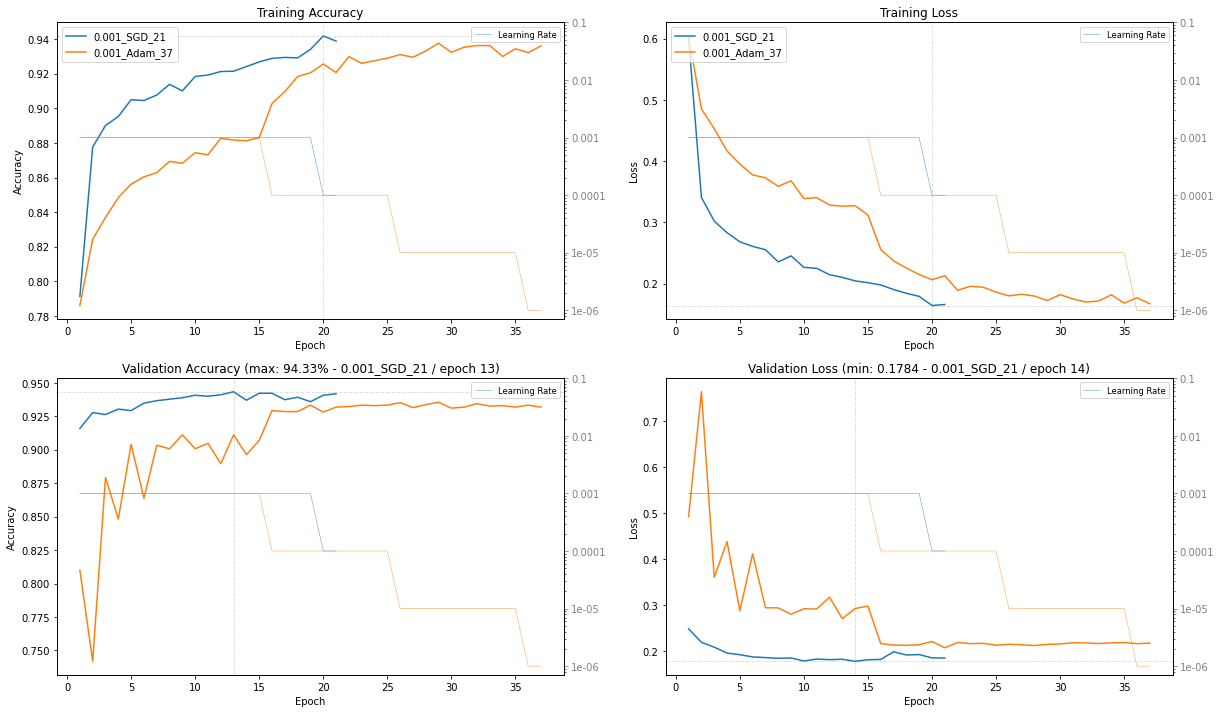

In [ ]:
plot_metrics()

In [ ]:
def plot_metrics_previous():
    
    def convert_to_cpu(tensor_list):
        return [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensor_list]

    all_train_accuracies_cpu = {k: convert_to_cpu(v) for k, v in all_train_accuracies.items()}
    all_val_accuracies_cpu = {k: convert_to_cpu(v) for k, v in all_val_accuracies.items()}
    all_train_losses_cpu = {k: convert_to_cpu(v) for k, v in all_train_losses.items()}
    all_val_losses_cpu = {k: convert_to_cpu(v) for k, v in all_val_losses.items()}

    fig, axs = plt.subplots(2, 2, figsize=(20, 12))

    for setting, accuracies in all_train_accuracies_cpu.items():
        axs[0, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)

    max_acc_value = max([max(accuracies) for accuracies in all_val_accuracies_cpu.values()])
    max_acc_setting = max(all_val_accuracies_cpu, key=lambda key: max(all_val_accuracies_cpu[key]))
    max_acc_epoch = all_val_accuracies_cpu[max_acc_setting].index(max_acc_value) + 1

    min_loss_value = min([min(losses) for losses in all_train_losses_cpu.values()])
    min_loss_setting = min(all_train_losses_cpu, key=lambda key: min(all_train_losses_cpu[key]))
    min_loss_epoch = all_train_losses_cpu[min_loss_setting].index(min_loss_value) + 1

    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].set_title("Training Accuracy")
    #axs[0, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 0].legend()

    for setting, losses in all_train_losses_cpu.items():
        axs[0, 1].plot(range(1, len(losses) + 1), losses, label=setting)

    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].set_title("Training Loss")
    #axs[0, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 1].legend()

    for setting, accuracies in all_val_accuracies_cpu.items():
        axs[1, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)

    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_title(f"Validation Accuracy (max: {max_acc_value * 100:.2f}% - {max_acc_setting} / epoch {max_acc_epoch})")
    #axs[1, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 0].legend()

    for setting, losses in all_val_losses_cpu.items():
        axs[1, 1].plot(range(1, len(losses) + 1), losses, label=setting)

    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_title(f"Validation Loss (min: {min_loss_value:.4f} - {min_loss_setting} / epoch {min_loss_epoch})")
    #axs[1, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 1].legend()

    plt.show()

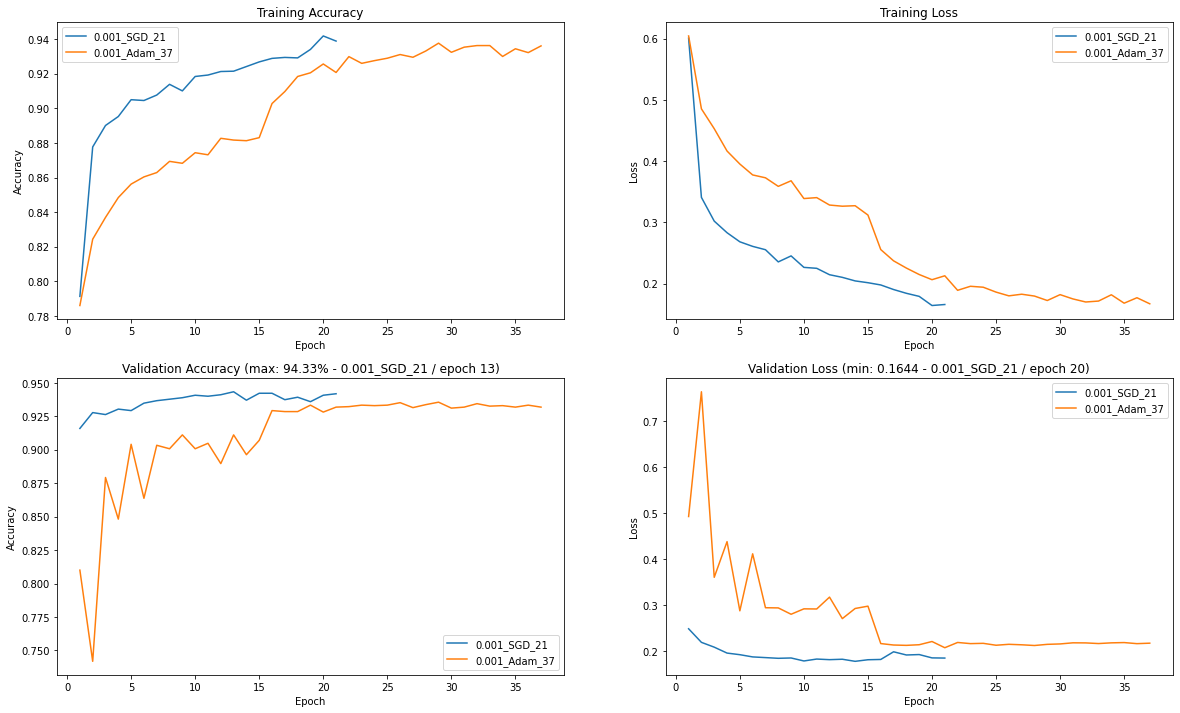

In [ ]:
plot_metrics_previous()

**ResNet18 (Residual Network) model architecture**:

This particular ResNet model has been slightly modified from its original architecture, the final fully connected layer has been adapted to output 6 features instead of the standard 1000 for ImageNet classification.

____________________________________________________________________________



**conv1:** A 2D convolutional layer with 3 input channels, 64 output channels, a kernel size of 7x7, a stride of 2, and padding of 3.

**bn1:** A batch normalization layer for the 64 output channels of the previous layer, with an epsilon value of 1e-05 and momentum of 0.1.

**relu:** A ReLU activation function applied in-place.

**maxpool:** A 2D max-pooling layer with a kernel size of 3, a stride of 2, and padding of 1.

**layer1 to layer4:** Four sequential layers, each containing two BasicBlock modules. Each BasicBlock consists of two convolutional layers with BatchNorm2d and ReLU activation functions, and optionally a downsample layer to adjust the input shape when required.

**layer1:** Two BasicBlocks with 64 input and output channels.

**layer2:** Two BasicBlocks with 128 output channels, and downsample from 64 to 128 channels.

**layer3:** Two BasicBlocks with 256 output channels, and downsample from 128 to 256 channels.

**layer4:** Two BasicBlocks with 512 output channels, and downsample from 256 to 512 channels.

**avgpool:** An adaptive average pooling layer that reduces the spatial dimensions to 1x1.

**fc:** A fully connected (linear) layer that takes 512 input features and outputs 6 features, corresponding to the number of classes in the classification task.

In [ ]:
# Testing the best model
from tqdm.auto import tqdm

# Load the saved model
model_path = os.path.join(mount_point, project_folder, 'best_model.pth')
class_names = list(dataset_paths.keys())

# Create the model architecture
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

# Load the model weights
if device.type == 'cuda':
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()
model = model.to(device)

all_preds = []
all_labels = []

softmax_scores = []
image_names = []

test_progress_bar = tqdm(dataloaders['test'], desc='Testing progress')

for inputs, labels, paths in test_progress_bar:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        softmax = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    softmax_scores.append(softmax.cpu())#.numpy())
    image_names.extend(paths)

    # Update progress bar
    test_progress_bar.set_postfix(acc=torch.sum(preds == labels.data).item() / len(labels), refresh=True)

accuracy = accuracy_score(all_labels, all_preds)
print(f'                           Test accuracy: {accuracy * 100:.2f}%')

#softmax_scores = np.concatenate(softmax_scores)
softmax_scores = torch.cat(softmax_scores)
image_names = [os.path.splitext(os.path.basename(p))[0] for p in image_names]

Testing progress:   0%|          | 0/24 [00:00<?, ?it/s]

                           Test accuracy: 93.93%


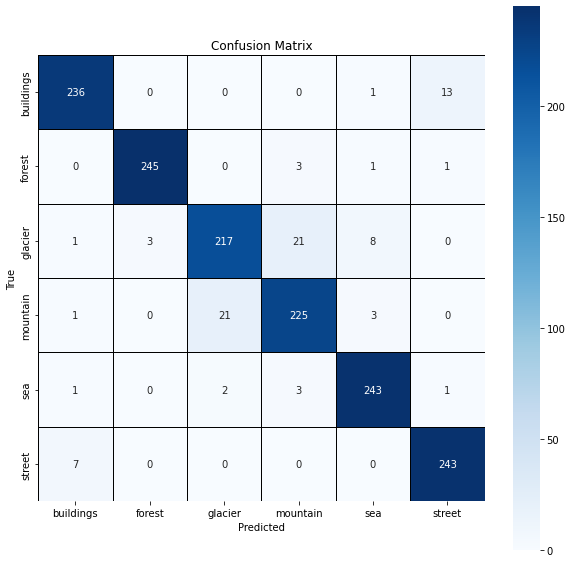

Classification Report:

              precision    recall  f1-score   support

   buildings       0.96      0.94      0.95       250
      forest       0.99      0.98      0.98       250
     glacier       0.90      0.87      0.89       250
    mountain       0.89      0.90      0.90       250
         sea       0.95      0.97      0.96       250
      street       0.94      0.97      0.96       250

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500



In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.5, linecolor='black', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:\n')
print(report)

#print(f'Softmax scores:\n\n {softmax_scores}\n\n')

for i, class_name in enumerate(class_names):
    # Get the softmax scores and image names for the current class
    mask = all_labels == i
    class_softmax_scores = softmax_scores[mask]
    class_image_names = np.array(image_names)[mask]

    # If there are no data points for the current class, skip plotting
    if len(class_softmax_scores) == 0:
        continue

    # Create a DataFrame for the softmax scores and image names
    df = pd.DataFrame(class_softmax_scores, columns=class_names)
    df['image'] = class_image_names

    # Plot the heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(df, cmap='Blues', square=True, linewidths=0.5, linecolor='black')
    plt.title(f'Softmax Scores for Class "{class_name}"')
    plt.xlabel('Class')
    plt.ylabel('Image')
    plt.show()

In [ ]:
softmax_scores

tensor([[1.8565e-06, 2.0049e-06, 3.1641e-03, 9.9678e-01, 5.3763e-05, 7.5880e-07],
        [2.8353e-05, 9.9934e-01, 4.1824e-04, 3.7632e-05, 1.4140e-04, 3.0707e-05],
        [3.0018e-05, 9.9591e-01, 2.1953e-03, 1.6543e-03, 1.7533e-04, 3.4509e-05],
        ...,
        [2.7969e-05, 4.8556e-08, 6.8240e-06, 7.1446e-06, 9.9996e-01, 2.5059e-06],
        [2.4423e-06, 7.2986e-07, 9.7109e-01, 2.8754e-02, 1.4817e-04, 1.0951e-06],
        [2.2529e-03, 1.7687e-04, 1.1861e-03, 2.3452e-05, 9.8669e-05, 9.9626e-01]])

In [ ]:
# Saving softmax scores (comment when running to compare with existing ones)
softmax_scores_path = os.path.join(mount_point, project_folder, softmax_folder, 'softmax_scores.npy')
image_labels_path = os.path.join(mount_point, project_folder, softmax_folder, 'image_labels.npy')

if not os.path.exists(softmax_scores_path):
    np.save(softmax_scores_path, softmax_scores)
    print(f'\nSoftmax scores saved to {softmax_scores_path}')
else: 
    print(f'\nSoftmax scores already stored in {softmax_scores_path}')

if not os.path.exists(image_labels_path):
    np.save(image_labels_path, np.array(image_names))
    print(f'\nImage labels saved to {image_labels_path}')
else: 
    print(f'\nImage labels already stored in {image_labels_path}')


Softmax scores saved to /content/drive/My Drive/IN4310/softmax/softmax_scores.npy

Image labels saved to /content/drive/My Drive/IN4310/softmax/image_labels.npy


In [ ]:
# Load saved softmax scores for comparison
if os.path.exists(os.path.join(mount_point, project_folder, softmax_folder, 'softmax_scores.npy')):
    saved_scores = np.load(os.path.join(mount_point, project_folder, softmax_folder, 'softmax_scores.npy'))
    saved_scores = saved_scores.astype(np.float32) # convert to float32
else:
    saved_scores = np.zeros_like(softmax_scores)

if os.path.exists(os.path.join(mount_point, project_folder, softmax_folder, 'image_labels.npy')):
    saved_labels = np.load(os.path.join(mount_point, project_folder, softmax_folder, 'image_labels.npy'))
    saved_labels = saved_labels.astype(str) # convert to string
else:
    saved_labels = np.zeros_like(np.array(image_names))

# Compare the computed scores against the saved ones
if np.allclose(softmax_scores, saved_scores): 
    print('\nThe computed and the saved softmax scores Match')
else:
    print('\nThe computed and the saved softmax scores Do not match :(\n')

# Compare the computed image labels against the saved ones
if np.array_equal(np.array(image_names).astype(str), saved_labels):
    print('\nThe computed and the saved image labels Match')
else:
    print('\nThe computed and the saved image labels Do not match :(\n')
    print('Image names',image_names)
    print('Stored image names',saved_labels)

    if saved_labels is not None:
        saved_labels = saved_labels.tolist() # convert numpy array to list
        diff = list(set(saved_labels) - set(image_names))
        print(f"\n{len(diff)} images in the saved labels but not in the computed labels:")
        print(diff)
        
        diff = list(set(image_names) - set(saved_labels))
        print(f"\n{len(diff)} images in the computed labels but not in the saved labels:")
        print(diff)


The computed and the saved softmax scores Match

The computed and the saved image labels Match


To display the top-10 ranked images and bottom-10 ranked images based on their classification scores, we can use the saved softmax scores and image names from the test set. We can then sort the images based on their classification scores and display the top and bottom images.

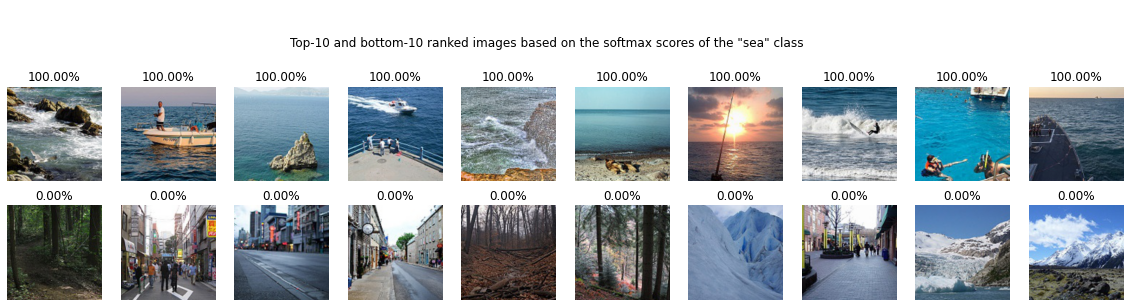

In [ ]:
# Display the top-10 and bottom-10 ranked images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
fig.suptitle(f'\n\nTop-10 and bottom-10 ranked images based on the softmax scores of the "sea" class', y=1.15)

# Calculate the score for each image and sort them in ascending and descending order
scores = softmax_scores[:, class_names.index('sea')].numpy()
ascending_indices = np.argsort(scores)
descending_indices = ascending_indices[::-1]

for i in range(10):
    # Top-10 ranked images
    top_image_path = os.path.join(test_data[descending_indices[i]])
    top_image = Image.open(top_image_path)
    top_image = data_transforms['visualization'](top_image)
    top_image_np = np.array(top_image)
    top_image_rescaled = (top_image_np / np.max(top_image_np)) * 255
    axs[0, i].imshow(torch.Tensor(top_image_rescaled).permute(1, 2, 0).numpy().astype(np.uint8))
    axs[0, i].axis('off')
    axs[0, i].set_title(f'{scores[descending_indices[i]]*100:.2f}%')

    # Bottom-10 ranked images
    bottom_image_path = os.path.join(test_data[ascending_indices[i]])
    bottom_image = Image.open(bottom_image_path)
    bottom_image = data_transforms['visualization'](bottom_image)
    bottom_image_np = np.array(bottom_image)
    bottom_image_rescaled = (bottom_image_np / np.max(bottom_image_np)) * 255
    axs[1, i].imshow(torch.Tensor(bottom_image_rescaled).permute(1, 2, 0).numpy().astype(np.uint8))
    axs[1, i].axis('off')
    axs[1, i].set_title(f'{scores[ascending_indices[i]]*100:.2f}%')

plt.show()

Image classes:

1. buildings
2. forest
3. glacier
4. mountain
5. sea
6. street

Enter the number corresponding to the desired class: 1


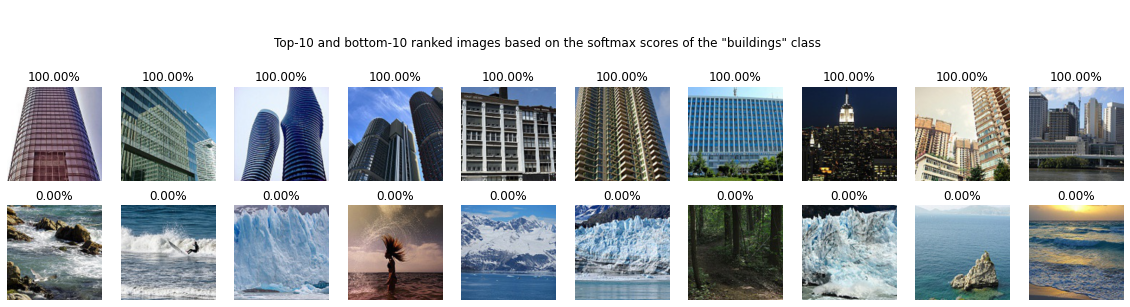

In [ ]:
class_names = list(dataset_paths.keys())

# Print the numbered table of classes
print('Image classes:\n')
for i, cls in enumerate(class_names):
    print(f'{i+1}. {cls}')

# Request a choice
choice = int(input('\nEnter the number corresponding to the desired class: '))
if choice < 1 or choice > len(class_names):
    print('Invalid choice')
else:
    chosen_class = class_names[choice-1]

    # Calculate the score for each image and sort them in ascending and descending order
    scores = softmax_scores[:, class_names.index(chosen_class)].numpy()
    ascending_indices = np.argsort(scores)
    descending_indices = ascending_indices[::-1]

    # Display the top-10 and bottom-10 ranked images
    fig, axs = plt.subplots(2, 10, figsize=(20, 4))
    fig.suptitle(f'\n\nTop-10 and bottom-10 ranked images based on the softmax scores of the "{chosen_class}" class', y=1.15)

    for i in range(10):
        # Top-10 ranked images
        top_image_path = os.path.join(test_data[descending_indices[i]])
        top_image = Image.open(top_image_path)
        top_image = data_transforms['visualization'](top_image)
        top_image_np = np.array(top_image)
        top_image_rescaled = (top_image_np / np.max(top_image_np)) * 255
        axs[0, i].imshow(torch.Tensor(top_image_rescaled).permute(1, 2, 0).numpy().astype(np.uint8))
        axs[0, i].axis('off')
        axs[0, i].set_title(f'{scores[descending_indices[i]]*100:.2f}%')

        # Bottom-10 ranked images
        bottom_image_path = os.path.join(test_data[ascending_indices[i]])
        bottom_image = Image.open(bottom_image_path)
        bottom_image = data_transforms['visualization'](bottom_image)
        bottom_image_np = np.array(bottom_image)
        bottom_image_rescaled = (bottom_image_np / np.max(bottom_image_np)) * 255
        axs[1, i].imshow(torch.Tensor(bottom_image_rescaled).permute(1, 2, 0).numpy().astype(np.uint8))
        axs[1, i].axis('off')
        axs[1, i].set_title(f'{scores[ascending_indices[i]]*100:.2f}%')

    plt.show()

#### **Task 2:** Internals of network feature map statistics

Choose 5 feature maps as outputs of modules.

`for nam, mod in model.named_modules()`: allows you to iterate through all modules of a network

For these 5 feature maps compute the average over 200 images of
– the percentage of non-positive values, averaged over all channels
and spatial elements of it.

100% would be equal to the total size of the feature map for one
image (batchsize= 1).

In networks with ReLU these are usually zeros. In Networks with
GELU, ELU, SELU activations they can be zero or negative.

In [ ]:
def get_feature_map_statistics(model, feature_map_layers, dataloader):
    feature_maps = {}
    hooks = []
    hook_stats = {name: {'non_positive_count': 0, 'total_count': 0} for name in feature_map_layers}

    def feature_map_hook(module, input, output, key):
        feature_maps[key] = output

    def statistics_hook(module, input, output, key):
        non_positive_count = (output <= 0).sum().item()
        total_count = output.numel()
        hook_stats[key]['non_positive_count'] += non_positive_count
        hook_stats[key]['total_count'] += total_count

    for name, module in model.named_modules():
        if name in feature_map_layers:
            feature_map_fn = lambda module, input, output, key=name: feature_map_hook(module, input, output, key)
            hooks.append(module.register_forward_hook(feature_map_fn))

            statistics_fn = lambda module, input, output, key=name: statistics_hook(module, input, output, key)
            hooks.append(module.register_forward_hook(statistics_fn))

    n_images = 0
    with torch.no_grad():
        for batch_idx, (images, labels, *_) in enumerate(dataloader):
            if n_images >= 200:
                break

            model(images.to(device))
            n_images += images.size(0)

    for hook in hooks:
        hook.remove()

    non_positive_percentages = {}
    for name in feature_map_layers:
        non_positive_percentage = 100 * hook_stats[name]['non_positive_count'] / hook_stats[name]['total_count']
        non_positive_percentages[name] = non_positive_percentage

    return feature_maps, non_positive_percentages

In [ ]:
# Create dataloaders for train, val, and test sets with a batch_size = 1
batch_size_ = 1

dataloader_4statistics = {
    'train': DataLoader(train_dataset, batch_size = batch_size_, shuffle = True, num_workers = num_workers),
    'valid': DataLoader(val_dataset, batch_size = batch_size_, shuffle = True, num_workers = num_workers),
    'test': DataLoader(test_dataset, batch_size = batch_size_, shuffle = False, num_workers = num_workers)
}

# Feature map layers
feature_map_layers = ['maxpool','layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

# Get a sample input image
input_image = torch.randn(1, 3, 224, 224)

#model_path = os.path.join(mount_point, 'best_model.pth')
#model.load_state_dict(torch.load(model_path, map_location=device))
#model.eval()

feature_maps, non_positive_percentages = get_feature_map_statistics(model, feature_map_layers, dataloader_4statistics['test'])

print('Feature map layers:\n')
for name, fmap in feature_maps.items():
    print(f"{name:<8}: {fmap.shape}")

print('\nThe percentage of non-positive values for selected feature maps:\n')
for name, non_positive_percentage in non_positive_percentages.items():
    print(f"{name:<8}: {non_positive_percentage:.2f}% non-positive values")

Feature map layers:

maxpool : torch.Size([1, 64, 56, 56])
layer1  : torch.Size([1, 64, 56, 56])
layer2  : torch.Size([1, 128, 28, 28])
layer3  : torch.Size([1, 256, 14, 14])
layer4  : torch.Size([1, 512, 7, 7])
avgpool : torch.Size([1, 512, 1, 1])

The percentage of non-positive values for selected feature maps:

maxpool : 23.20% non-positive values
layer1  : 23.77% non-positive values
layer2  : 49.31% non-positive values
layer3  : 55.20% non-positive values
layer4  : 43.12% non-positive values
avgpool : 1.38% non-positive values


**Task 3:**  Internals of network feature map statistics (MSc)

In [ ]:
def get_feature_maps(images, model, feature_map_layers): # to speed-up compute_top_k_eigenvalues()
    """
    Get feature maps for input images in specified layers of a model.
    Args:
        images (tensor): Input images
        model (nn.Module): The model
        feature_map_layers (list): List of layer names to extract feature maps from
    Returns:
        feature_maps (dict): Dictionary with layer names as keys and feature maps as values
    """
    feature_maps = {}
    hooks = []

    def hook_fn(module, input, output, key):
        feature_maps[key] = output.detach()

    for name, module in model.named_modules():
        if name in feature_map_layers:
            hook = module.register_forward_hook(lambda module, input, output, key=name: hook_fn(module, input, output, key))
            hooks.append(hook)

    with torch.no_grad():
        model(images)

    for hook in hooks:
        hook.remove()

    return feature_maps


def compute_top_k_eigenvalues(model, feature_map_layers, dataloader, k=1000):
    device = next(model.parameters()).device
    top_k_eigenvalues = {}

    for layer in feature_map_layers:
        top_k_eigenvalues[layer] = []

    # Iterate through the dataset
    n_images = 0
    with tqdm(total=min(len(dataloader.dataset), 200)) as pbar:
        for batch_idx, (images, labels, *_) in enumerate(dataloader):
            if n_images >= 200:
                break

            with torch.no_grad():
                feature_maps = get_feature_maps(images.to(device), model, feature_map_layers)

            # Compute the mean of the feature maps over spatial dimensions
            for name, fmap in feature_maps.items():
                mean_fmap = torch.mean(fmap, dim=(2, 3)).cpu().numpy()
                top_k_eigenvalues[name].append(mean_fmap)

            n_images += len(images)
            pbar.update(len(images))

    # Calculate the empirical covariance matrix and obtain the top-k eigenvalues
    for name in feature_map_layers:
        data = np.concatenate(top_k_eigenvalues[name], axis=0)
        cov_matrix = np.cov(data, rowvar=False)
        eigenvalues, _ = np.linalg.eigh(cov_matrix)
        top_k_eigenvalues[name] = np.sort(eigenvalues)[-k:]

    # Plot the sorted top-k eigenvalues
    fig, ax = plt.subplots(figsize=(10, 6))
    for name, eigenvalues in top_k_eigenvalues.items():
        ax.plot(np.flip(eigenvalues), label=name)
    ax.set_title('Top-k Eigenvalues of Empirical Covariance Matrix')
    ax.set_xlabel('Eigenvalue Index')
    ax.set_ylabel('Eigenvalue')
    ax.legend()
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 0.05)
    plt.show()    

In [ ]:
init_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = init_model.fc.in_features
init_model.fc = nn.Linear(num_features, len(class_names))

cifar10_dataset = datasets.CIFAR10(root = data_folder, train=False, download=True, transform=data_transforms['test'])
cifar10_subset = torch.utils.data.Subset(cifar10_dataset, range(200))
dataloader_cifar = torch.utils.data.DataLoader(cifar10_subset, batch_size=1, shuffle=False, num_workers=0)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/data/cifar-10-python.tar.gz to /content/data


  0%|          | 0/200 [00:00<?, ?it/s]

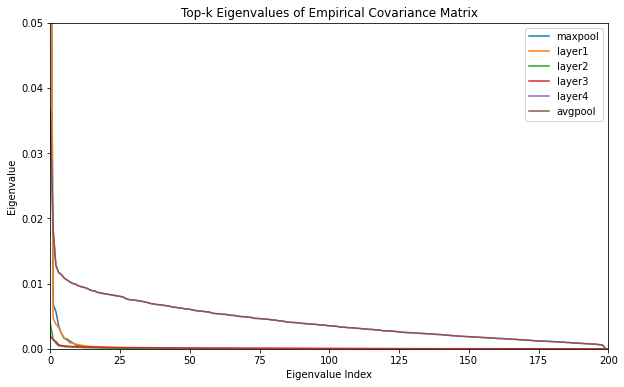

  0%|          | 0/200 [00:00<?, ?it/s]

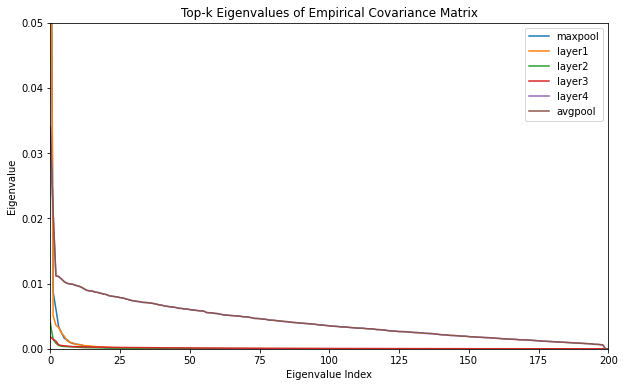

  0%|          | 0/200 [00:00<?, ?it/s]

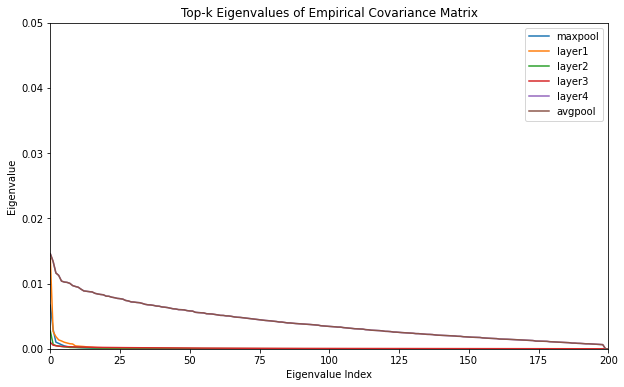

  0%|          | 0/200 [00:00<?, ?it/s]

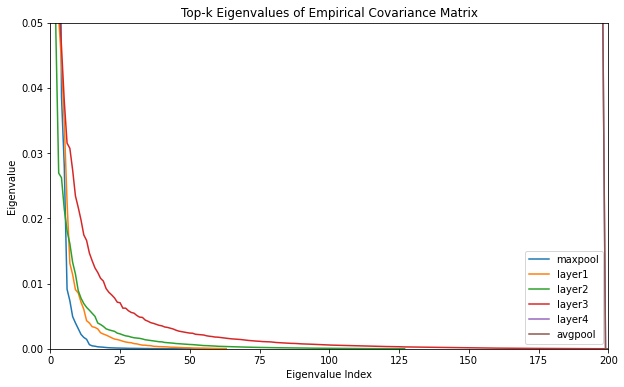

In [ ]:
compute_top_k_eigenvalues(init_model, feature_map_layers, dataloader_4statistics['test'], k=1000)
compute_top_k_eigenvalues(init_model, feature_map_layers, dataloader_4statistics['valid'], k=1000)
compute_top_k_eigenvalues(init_model, feature_map_layers, dataloader_cifar, k=1000)
compute_top_k_eigenvalues(model, feature_map_layers, dataloader_4statistics['test'], k=1000)